In [2]:
# Cell 1: Import All Necessary Libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# Data processing and evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Models
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

# Machine Learning Model
import xgboost as xgb

# Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Set display options for better visibility
pd.set_option('display.max_columns', None)
print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


In [3]:
# Cell 2 (Corrected for Status Column): Data Cleaning and File Creation

import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('data.csv',encoding='latin-1')

# --- 2.1 Cleaning and Type Conversion ---
pollutant_cols = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
for col in pollutant_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns=['stn_code', 'sampling_date', 'agency', 'location_monitoring_station'], errors='ignore')

# --- 2.2 Imputation ---
# Fill missing pollutant values with the mean of the column
for col in pollutant_cols:
    df[col] = df[col].fillna(df[col].mean())

# --- 2.3 Feature Engineering: Air Quality Status Column ---
def get_aq_status(rspm):
    if not pd.isna(rspm):
        if rspm <= 50: return 'Good'
        elif rspm <= 100: return 'Satisfactory'
        elif rspm <= 250: return 'Moderate'
        elif rspm <= 350: return 'Poor'
        elif rspm <= 430: return 'Very Poor'
        else: return 'Severe'
    return 'Unknown' # Return 'Unknown' if rspm is still NaN for some reason

# Create the status column
df['AQ_Status'] = df['rspm'].apply(get_aq_status)

# --- Verification Step (for you to see it's working) ---
print("--- Verifying Status Column Creation ---")
print("Value counts for AQ_Status column before aggregation:")
print(df['AQ_Status'].value_counts())
print("-" * 40)


# --- 2.4 Aggregation (Per-State Model) ---
# A more robust function to find the most common status
def get_most_common_status(series):
    if not series.mode().empty:
        return series.mode().iloc[0]
    return 'Unknown'

# Aggregate data by date and state
agg_df = df.groupby(['date', 'state']).agg(
    avg_rspm=('rspm', 'mean'),
    avg_so2=('so2', 'mean'),
    avg_no2=('no2', 'mean'),
    Air_Quality_Status=('AQ_Status', get_most_common_status) # Use the new robust function
).reset_index()

# Round the averages for readability
agg_df['avg_rspm'] = agg_df['avg_rspm'].round(2)
agg_df['avg_so2'] = agg_df['avg_so2'].round(2)
agg_df['avg_no2'] = agg_df['avg_no2'].round(2)

# --- 2.5 SAVE THE HUMAN-READABLE CSV (YOUR REQUEST) ---
agg_df.to_csv('human_readable_air_quality.csv', index=False)
print("\n✅ Human-readable file saved: 'human_readable_air_quality.csv'")
print("Head of the final human-readable file:")
print(agg_df.head())


# --- 2.6 PREPARE DATA FOR MODELS (STILL REQUIRED) ---
STATE_TO_PREDICT = 'Maharashtra'
ts_state_df = agg_df[agg_df['state'] == STATE_TO_PREDICT]

final_ts_df = ts_state_df[['date', 'avg_rspm']].rename(
    columns={'date': 'ds', 'avg_rspm': 'y'}
)

final_ts_df.to_csv('clean_air_quality_timeseries.csv', index=False)
print(f"\n✅ Model-ready file for {STATE_TO_PREDICT} saved: 'clean_air_quality_timeseries.csv'")

# --- 2.7 Split the data for the next steps ---
TEST_SIZE = 30
train_df = final_ts_df.iloc[:-TEST_SIZE].copy()
test_df = final_ts_df.iloc[-TEST_SIZE:].copy()
y_actual = test_df['y'].values
model_results = {} # Reset results for the new run

print(f"\nData is ready for model training.")

C:\Users\LeNoVo\AppData\Local\Temp\ipykernel_15820\3982097164.py:7: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data.csv',encoding='latin-1')


--- Verifying Status Column Creation ---
Value counts for AQ_Status column before aggregation:
AQ_Status
Moderate        191739
Satisfactory    144771
Good             79985
Poor             14689
Very Poor         2936
Severe            1622
Name: count, dtype: int64
----------------------------------------

✅ Human-readable file saved: 'human_readable_air_quality.csv'
Head of the final human-readable file:
        date          state  avg_rspm  avg_so2  avg_no2 Air_Quality_Status
0 1987-01-01        Gujarat    108.83    19.70    15.00           Moderate
1 1987-01-01      Rajasthan    108.83    10.83    25.81           Moderate
2 1987-01-01  Uttar Pradesh    108.83    16.10    25.81           Moderate
3 1987-01-01    West Bengal    108.83    47.04    86.37           Moderate
4 1987-01-02        Gujarat    108.83    26.45    45.40           Moderate

✅ Model-ready file for Maharashtra saved: 'clean_air_quality_timeseries.csv'

Data is ready for model training.


In [4]:
# Train and Evaluate ARIMA and Prophet Models

# ARIMA Model ---
print("\n--- Training ARIMA Model ---")
arima_train_series = train_df.set_index('ds')['y']
try:
    m_arima = ARIMA(arima_train_series, order=(5, 1, 0)).fit()
    y_pred_arima = m_arima.forecast(steps=TEST_SIZE).values
    mae_arima = mean_absolute_error(y_actual, y_pred_arima)
    rmse_arima = np.sqrt(mean_squared_error(y_actual, y_pred_arima))
    model_results['ARIMA'] = {'MAE': mae_arima, 'RMSE': rmse_arima, 'Model': m_arima}
    print(f"✅ ARIMA - MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
except Exception as e:
    print(f"❌ ARIMA failed: {e}")
    model_results['ARIMA'] = {'MAE': np.inf, 'RMSE': np.inf, 'Model': None}

# Prophet Model ---
print("\n--- Training Prophet Model ---")
m_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
m_prophet.fit(train_df)
y_pred_prophet = m_prophet.predict(test_df[['ds']])['yhat'].values
mae_prophet = mean_absolute_error(y_actual, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_actual, y_pred_prophet))
model_results['Prophet'] = {'MAE': mae_prophet, 'RMSE': rmse_prophet, 'Model': m_prophet}
print(f"✅ Prophet - MAE: {mae_prophet:.2f}, RMSE: {rmse_prophet:.2f}")


--- Training ARIMA Model ---


C:\Users\LeNoVo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LeNoVo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LeNoVo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LeNoVo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is

✅ ARIMA - MAE: 7.52, RMSE: 9.33

--- Training Prophet Model ---


19:10:36 - cmdstanpy - INFO - Chain [1] start processing
19:10:40 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet - MAE: 7.91, RMSE: 10.02


In [5]:
# Train and Evaluate XGBoost Model

print("\n--- Training XGBoost Model ---")

# Feature Engineering ---
def create_features(df_in):
    df_out = df_in.copy()
    df_out['dayofweek'] = df_out['ds'].dt.dayofweek
    df_out['month'] = df_out['ds'].dt.month
    df_out['year'] = df_out['ds'].dt.year
    df_out['lag_7'] = df_out['y'].shift(7)
    return df_out.dropna()

full_df_features = create_features(final_ts_df)
train_features = full_df_features[full_df_features['ds'].isin(train_df['ds'])]
test_features = full_df_features[full_df_features['ds'].isin(test_df['ds'])]
FEATURES = ['dayofweek', 'month', 'year', 'lag_7']
X_train, y_train = train_features[FEATURES], train_features['y']
X_test, y_test = test_features[FEATURES], test_features['y']

# Training and Evaluation ---
m_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
m_xgb.fit(X_train, y_train)
y_pred_xgb = m_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
model_results['XGBoost'] = {'MAE': mae_xgb, 'RMSE': rmse_xgb, 'Model': m_xgb}
print(f"✅ XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")


--- Training XGBoost Model ---
✅ XGBoost - MAE: 10.11, RMSE: 13.87


In [6]:
#  Train and Evaluate LSTM Model

print("\n--- Training LSTM Model (this will show progress) ---")
from tensorflow.keras.layers import Input

# Data Preparation (with Corrected Sequence Function) 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_ts_df[['y']])
train_data = scaled_data[:-TEST_SIZE]
test_data = scaled_data[len(train_data) - 60:]

# Function to create sequences of data
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    # The "- 1" was removed from the end of the range to create the correct number of samples
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train_lstm, y_train_lstm = create_dataset(train_data, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_data, time_step)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

#  Build and Train Model ---
m_lstm = Sequential([
    Input(shape=(time_step, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
m_lstm.compile(optimizer='adam', loss='mean_squared_error')
m_lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), 
           epochs=20, batch_size=64, verbose=1)

# Prediction and Evaluation ---
y_pred_lstm_scaled = m_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm_scaled)

mae_lstm = mean_absolute_error(y_actual, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_actual, y_pred_lstm))
model_results['LSTM'] = {'MAE': mae_lstm, 'RMSE': rmse_lstm, 'Model': m_lstm}
print(f"✅ LSTM - MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


--- Training LSTM Model (this will show progress) ---
Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0124 - val_loss: 0.0027
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - loss: 0.0090 - val_loss: 0.0021
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0089 - val_loss: 0.0018
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0088 - val_loss: 0.0032
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0084 - val_loss: 0.0014
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0082 - val_loss: 0.0022
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 0.0080 - val_loss: 0.0021
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.0078 - val_loss: 0.0018
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0077 - val_loss: 0.0015
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0076 - val_loss: 


--- Final Model Performance Summary ---
               MAE       RMSE
ARIMA     7.524732    9.32865
Prophet   7.906711  10.024629
LSTM      9.933629  11.921086
XGBoost  10.112046  13.871392


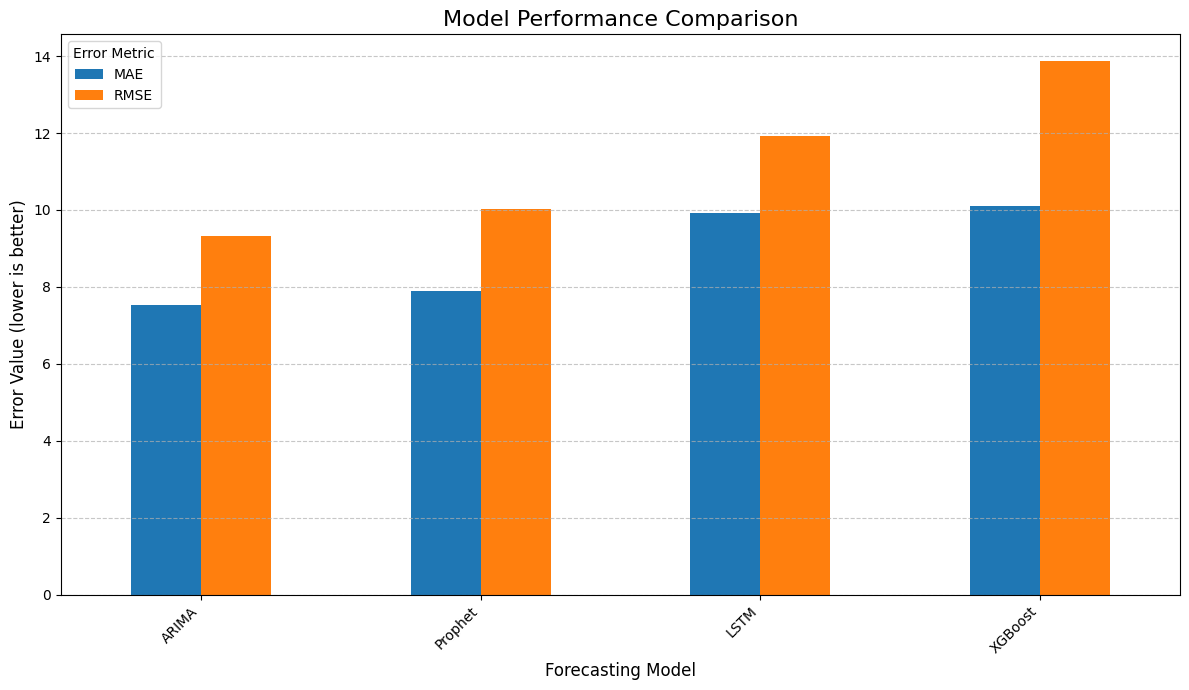


🎉 Best performing model based on MAE is 'ARIMA'.
✅ Model saved for inference as 'best_air_quality_model.joblib'.


In [8]:
# Final Model Comparison and Saving

import matplotlib.pyplot as plt
import pandas as pd

print("\n--- Final Model Performance Summary ---")

# Create a DataFrame for easy comparison and sort by MAE
# Ensure 'Model' column is dropped if it exists from previous runs
performance_df = pd.DataFrame(model_results).T
if 'Model' in performance_df.columns:
    performance_df = performance_df.drop(columns='Model')

performance_df = performance_df.sort_values('MAE')
print(performance_df)

# Create a bar chart to compare model errors
fig, ax = plt.subplots(figsize=(12, 7))
performance_df.plot(kind='bar', ax=ax)

# Set chart titles and labels
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_ylabel('Error Value (lower is better)', fontsize=12)
ax.set_xlabel('Forecasting Model', fontsize=12)
ax.set_xticklabels(performance_df.index, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title='Error Metric')

# Display the plot
plt.tight_layout()
plt.show()


best_model_name = performance_df.index[0]
best_model_obj = model_results[best_model_name]['Model']

print(f"\n🎉 Best performing model based on MAE is '{best_model_name}'.")

# --- Save the best-performing model for inference ---
if best_model_name == 'LSTM':
    try:
        # Keras native saving format is preferred for neural networks
        best_model_obj.save('best_air_quality_model.h5')
        print("✅ Model saved for inference as 'best_air_quality_model.h5'.")
    except Exception as e:
        print(f"\nCould not save Keras model directly. Error: {e}")
else:
    # Use joblib for other models
    joblib.dump(best_model_obj, 'best_air_quality_model.joblib')
    print("✅ Model saved for inference as 'best_air_quality_model.joblib'.")